# mitoFociCounter analysis

## Comparing WT experiments

AUTHOR: Timo Rey, EMBO Postdoctoral Fellow, MRC Mitochondrial Biology Unit Cambridge 2021/22

LICENSE: GNU 3.0

This script takes output .csv files from the Fiji-macro mtFociCounter(beta) and returns graphs and statistics to interpret the data from several replicates
  
The workflow is as follows:  
1) import libraries  
2) define functions  
3) load data  
4) compute additional descriptors  
5) analysis - bulk descriptors  
&nbsp;&nbsp;&nbsp;&nbsp; i) prominence sweep  
&nbsp;&nbsp;&nbsp;&nbsp; ii) foci count  
&nbsp;&nbsp;&nbsp;&nbsp; iii) mitochondrial area  
&nbsp;&nbsp;&nbsp;&nbsp; iv) correlation between foci-count and mitochondrial area  
&nbsp;&nbsp;&nbsp;&nbsp; v) foci density  
6) analysis - heterogeneity  
&nbsp;&nbsp;&nbsp;&nbsp; i) foci count  
&nbsp;&nbsp;&nbsp;&nbsp; ii) mitochondrial area  
&nbsp;&nbsp;&nbsp;&nbsp; iii) foci density  
  
&nbsp;&nbsp;&nbsp;&nbsp; iv) technical replicates

### 1) import libraries

In [1]:
from pathlib import Path
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pylab
import scipy.stats as stats
from scipy.stats import shapiro
from statannot import add_stat_annotation
import warnings
warnings.filterwarnings('ignore')         # note: only un-hash this once you are sure about your code. 

### 2) define functions

In [2]:
# Find all CSV files in input directory:
def findCSV(inputDir, filename="", prnt=False):
    """Looks for csv-files with [optional] filename in input directory.
    Returns a parsed list of files."""
    
    directory = Path(inputDir)
    all_txt = directory.glob('*'+filename+'*.csv')                            # all subdirectories will be searched
    txtList = sorted(all_txt)                                                 # because 'generator object' (.glob) != list
    print("There is/are %r file(s) in this folder and all subfolders." %len(txtList))  

    # Option: print path of the files and the identifiers
    if prnt:
        print("The files are:\n")
        pp = pprint.PrettyPrinter(indent = 1)
        pp.pprint(list(zip(txtList, range(len(txtList)))))
    
    return txtList

### 3) load data

In [3]:
# Find all files:
inputDir = r'C:\Users\yourUserName\Desktop\2022_FociCounter\todaysSamples'  # define directory with input files
filetag = "Results"                                                         # define tag to find results files
outDir = inputDir+"/wt_"                                                    # will create a new subdirectory with output files

infiles = findCSV(inputDir,filetag)                                         # find files

There is/are 7 file(s) in this folder and all subfolders.


In [4]:
# Read files:
df_in     = pd.DataFrame()                          # create empty DF
for i in infiles:
    df    = pd.read_csv(i, names=['img','area','%mito','prominence','foci_count','cell_line','date','sample_type','sample'])
    # note: above list is optimised for use-cases WITH mitochondria channel. Adapt otherwise.
    df_in = df_in.append(df, ignore_index=True)
    
# Find descriptors in image-names:                                         # note: this is file-naming dependent!
for index in df_in.index:                                                  # for every entry (6 per single cell [1 per prominence])
    location                       = df_in.loc[index,'img']                # find image-name
    words                          = location.split("_")                   # split image name into subsections using '_' as separator
    df_in.loc[index,"cell_line"]   = words[2]
    df_in.loc[index,"date"]        = words[0].replace('../', '') 
    df_in.loc[index,"sample_type"] = words[3]
    df_in.loc[index,"sample"]      = words[1]

### 4) compute additional descriptors

In [5]:
# compute mitochondrial area:
df_in['mito_area'] = df_in['area']*df_in['%mito']/100                      # mito_area = cell area * percentage of mito (in pixels)

optional:

In [6]:
# correct pixel size:
df_in['mito_inUm'] = df_in['mito_area']

# voxel size with 100X 1.45NA objective, Andor:
# 0.0603umx0.0603um per pixel
FirstDays = 0.0603*0.0603

# wrong meta-data for 20220708:
# 0.1508umx0.1508um per pixel
LastDay = 0.1508*0.1508
# compute conversion factor
conversion = LastDay/FirstDays

for index in df_in.index:
    number = df_in.loc[index,'date']
    if number == '20220708':
        df_in.loc[index,"mito_inUm"] = df_in.loc[index,"mito_area"]/conversion

In [7]:
# compute foci-density:
df_in['foci_density'] = df_in['foci_count']/df_in['mito_inUm']          # normalise foci by mito area

# compute number of cells analysed:
nCells = len(df_in[df_in['prominence']==122])                           # need to adapt this number if change prominence sweep
print ("Number of cells: "+str(nCells))

Number of cells: 481


## 5) analysis - bulk descriptors

#### i) prominence

Text(0, 0.5, 'mtDNA foci-count')

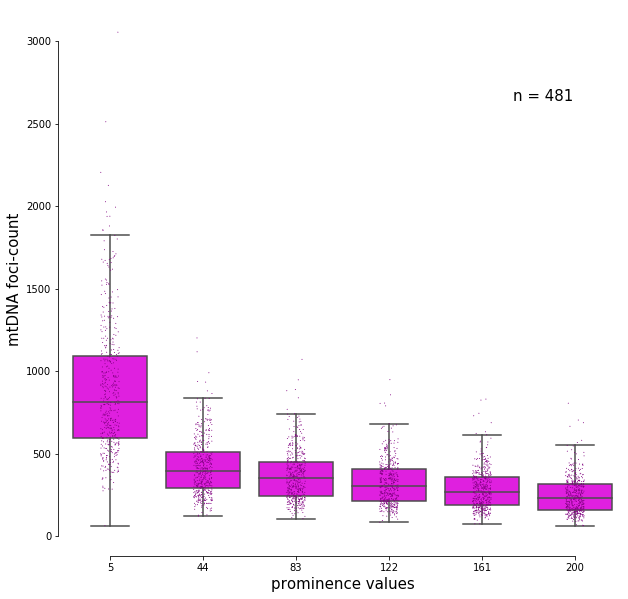

In [8]:
# plot & save figure with parameter sweep:

f, ax = plt.subplots(figsize=(10, 10))                                  # create figure & axe object
sns.boxplot(x="prominence", y="foci_count", color='magenta', data=df_in, showfliers = False)
sns.stripplot(x="prominence", y="foci_count", color='purple', data=df_in, size=1)
sns.despine(offset=5, trim=True)

f.text(0.75, 0.75,'n = '+str(nCells), fontsize=15)                      # add text
ax.set_xlabel("prominence values", fontsize = 15)
ax.set_ylabel("mtDNA foci-count", fontsize = 15)

f.savefig(Path(outDir+"FociProminence.svg"))

In [10]:
# choose a prominence value for following analysis:

prom_val = int(input("Which prominence value would you like to use?\t"))
df_fix = df_in[df_in['prominence']==prom_val]
print("You fixed prominence at: "+str(prom_val))

Which prominence value would you like to use?	122
You fixed prominence at: 122


#### ii) foci count

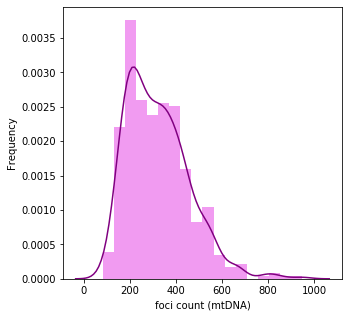

In [11]:
# plot distribution of foci-count (KDE & histogram):

fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(df_fix['foci_count'],color='purple',hist_kws={"linewidth": 1, "alpha": 0.8,"color": "violet"}, kde=True)
ax.set(xlabel = "foci count (mtDNA)", ylabel = "Frequency")

fig.savefig(Path(outDir+"mtFoci.svg"))

Test normality:

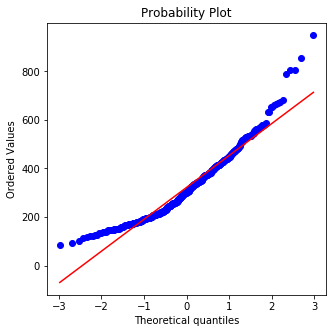

In [12]:
# create Q-Q plot for visual inspection:

fig, ax = plt.subplots(figsize = (5,5))
plt.show(stats.probplot(df_fix['foci_count'], dist='norm', plot=pylab))
fig.savefig(Path(outDir+"QQfoci.png"))

In [13]:
# Test Normality with Shapiro-Wilk test:

# define alpha:
alpha = 0.05

stat, p=shapiro(df_fix['foci_count'])
print("the p-value is:",p)

# evaluate:
if p > alpha:
    print("Gaussian!")
else:
    print("not likely to be normally distributed.")

the p-value is: 1.004245081190347e-12
not likely to be normally distributed.


Compute sample descriptors:

In [14]:
# for gaussian distributions:
print ("The average (mean) number of foci is:\t\t"+str(round(df_fix['foci_count'].mean())))
print ("Standard deviation of foci count is:\t\t"+str(round(df_fix['foci_count'].std())))
CV_foci = round(df_fix['foci_count'].std()/df_fix['foci_count'].mean()*100,1) # std / mean
print ("Coefficient of variation for foci count is:\t"+str(CV_foci)+"%\n")

# for non-normal distributions:
print ("The median number of foci is:\t\t\t"+str(round(df_fix['foci_count'].median())))
q1 = df_fix['foci_count'].quantile(0.25)
q3 = df_fix['foci_count'].quantile(0.75)
iqr = q3 - q1
print ("Interquartile range for foci is:\t\t"+str(iqr))

The average (mean) number of foci is:		322.0
Standard deviation of foci count is:		135.0
Coefficient of variation for foci count is:	41.8%

The median number of foci is:			302.0
Interquartile range for foci is:		193.0


#### iii) mitochondrial area

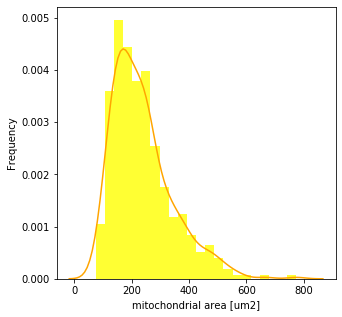

In [15]:
# plot distribution of mitochondrial area (KDE & histogram):

fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(df_fix['mito_inUm'],color='orange',hist_kws={"linewidth": 1, "alpha": 0.8, "color": "yellow"}, kde=True)
ax.set(xlabel = "mitochondrial area [um2]", ylabel = "Frequency")

fig.savefig(Path(outDir+"mtArea.svg"))

Test normality:

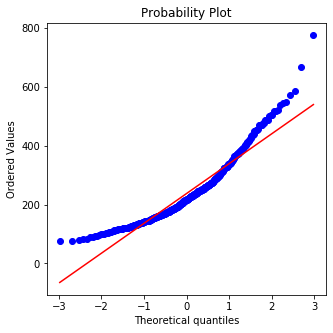

In [16]:
# create Q-Q plot for visual inspection:

fig, ax = plt.subplots(figsize = (5,5))
plt.show(stats.probplot(df_fix['mito_inUm'], dist='norm', plot=pylab))
fig.savefig(Path(outDir+"QQmito.svg"))

In [17]:
# Test Normality with Shapiro-Wilk test:

# define alpha:
alpha = 0.05

stat, p=shapiro(df_fix['mito_inUm'])
print("the p-value is:",p)

# evaluate:
if p > alpha:
    print("Gaussian!")
else:
    print("not likely to be normally distributed.")

the p-value is: 6.561636017112004e-16
not likely to be normally distributed.


Compute sample descriptors:

In [20]:
# for Normal data:
print ("The average (mean) number of foci is:\t\t\t"+str(round(df_fix['mito_inUm'].mean(),2)))
print ("Standard deviation of mitochondrial area is:\t\t"+str(round(df_fix['mito_inUm'].std(),2)))
CV_area = round(df_fix['mito_inUm'].std()/df_fix['mito_inUm'].mean()*100,1) # std / mean
print ("Coefficient of variation for mitochondrial area is:\t"+str(CV_area)+"%\n")

# for non-Gaussian:
print ("The median of mitochondrial area is:\t\t\t"+str(round(df_fix['mito_inUm'].median(),2)))
q1 = df_fix['mito_inUm'].quantile(0.25)
q3 = df_fix['mito_inUm'].quantile(0.75)
iqr = q3 - q1
print ("Interquartile range for mito area is:\t\t\t"+str(round(iqr,2)))

The average (mean) number of foci is:			237.43
Standard deviation of mitochondrial area is:		105.76
Coefficient of variation for mitochondrial area is:	44.5%

The median of mitochondrial area is:			216.69
Interquartile range for mito area is:			125.7


#### iv) correlation between foci-count and mitochondrial area

In [21]:
# compute correlation:

correlation = np.corrcoef(df_fix['foci_count'], df_fix['mito_inUm'])
print('The correlation coefficient between mtDNA foci-count and mitochondrial area is: ', round(correlation[0,1], 2))

The correlation coefficient between mtDNA foci-count and mitochondrial area is:  0.87


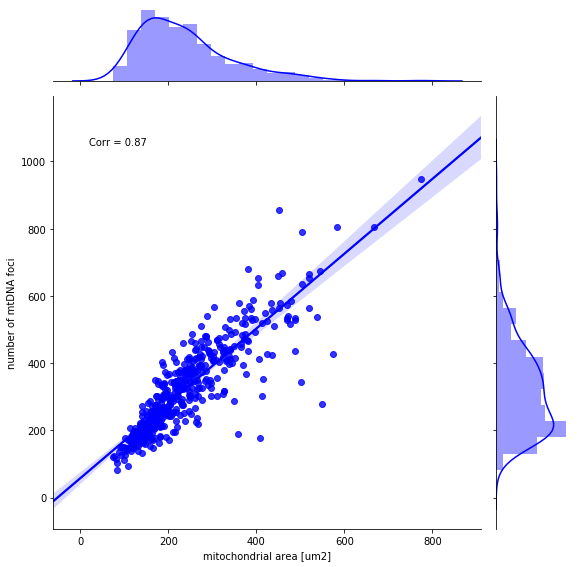

In [22]:
# plot correlation:

g = sns.jointplot(x="mito_inUm", y="foci_count", data=df_fix, kind="reg", truncate=False, color='b', height=8)
g.set_axis_labels(xlabel = "mitochondrial area [um2]", ylabel = "number of mtDNA foci")
plt.text(20, 1050,'Corr = '+str(round(correlation[0,1], 2)), fontsize=10)       # add text - adapt location depending on data

g.savefig(Path(outDir+"FociAreaCorr.svg"))

#### v) foci density

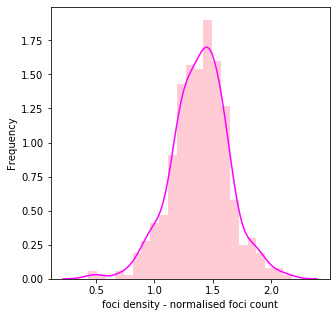

In [23]:
# plot distribution of foci-density (KDE & histogram):

fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(df_fix['foci_density'],color='magenta',hist_kws={"linewidth": 1, "alpha": 0.8, "color": "pink"}, kde=True)
ax.set(xlabel = "foci density - normalised foci count", ylabel = "Frequency")

fig.savefig(Path(outDir+"fociDensity.svg"))

Test normality:

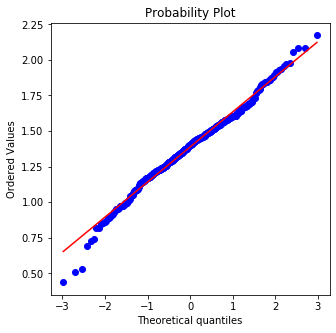

In [24]:
# create Q-Q plot for visual inspection:

fig, ax = plt.subplots(figsize = (5,5))
plt.show(stats.probplot(df_fix['foci_density'], dist='norm', plot=pylab))

fig.savefig(Path(outDir+"QQdensity.svg"))

In [25]:
# Test Normality with Shapiro-Wilk test:

# define alpha:
alpha = 0.05

stat, p=shapiro(df_fix['foci_density'])
print("the p-value is:",p)

# evaluate:
if p > alpha:
    print("Gaussian!")
else:
    print("not likely to be normally distributed.")

the p-value is: 0.0009846886387094855
not likely to be normally distributed.


optional:  
&nbsp;&nbsp;&nbsp;&nbsp; Normality analysis after outlier removal.

In [29]:
# Test Normality with Shapiro-Wilk test:

# define alpha:
alpha = 0.01

stat, p=shapiro(df_fix[df_fix['foci_density']>0.75]['foci_density'])


outliers = len(df_fix['foci_density'])-len(df_fix[df_fix['foci_density']>0.75]['foci_density'])
print("you removed",outliers,"outliers.")
print("the p-value now is:",p)

# evaluate:
if p > alpha:
    print("That's Gaussian!")
else:
    print("not likely to be normally distributed.")

you removed 6 outliers
the p-value is: 0.044536665081977844
Gaussian!


Compute sample descriptors:

In [26]:
# for Normal data:
print ("The average (mean) foci density is:\t\t\t"+str(round(df_fix['foci_density'].mean(),3)))
print ("Standard deviation of foci density is:\t\t\t"+str(round(df_fix['foci_density'].std(),3)))
CV_density = round(df_fix['foci_density'].std()/df_fix['foci_density'].mean()*100,1) # std / mean
print ("Coefficient of variation for foci density is:\t\t"+str(CV_density)+"%\n")

# for non-Normal data:
print ("The median foci density per um2 is:\t\t\t"+str(round(df_fix['foci_density'].median(),3)))
q1 = df_fix['foci_density'].quantile(0.25)
q3 = df_fix['foci_density'].quantile(0.75)
iqr = q3 - q1
print ("Interquartile range for foci-density is:\t\t"+str(round(iqr,3)))

The average (mean) foci density is:			1.388
Standard deviation of foci density is:			0.247
Coefficient of variation for foci density is:		17.8%

The median foci density per um2 is:			1.401
Interquartile range for foci-density is:		0.305


### 6) analysis - heterogeneity

In [ ]:
# plot and analyse day-to-day heterogeneity:

# define what to compare:
sorter             = ["20220603","20220706", "20220708"]
box_pairs          = [("20220603", "20220706"), ("20220706", "20220708"), ("20220603", "20220708")]
testtype           = 'Mann-Whitney'

#### i) foci-count:

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

20220603 v.s. 20220706: Mann-Whitney-Wilcoxon test two-sided P_val=1.842e-10 U_stat=4.609e+03
20220706 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=2.706e-05 U_stat=1.442e+04
20220603 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=8.935e-04 U_stat=1.389e+04


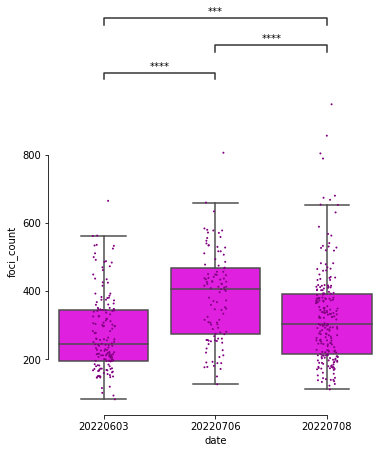

In [30]:
# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="date", y="foci_count", color='magenta', data=df_fix, showfliers = False, ax=axes)
sns.stripplot(x="date", y="foci_count", color="purple", data=df_fix, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=df_fix, x="date", y="foci_count", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)

plt.savefig(Path(outDir+"fociCountPerDayStats.svg"))

#### iI) mitochondrial area:

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

20220603 v.s. 20220706: Mann-Whitney-Wilcoxon test two-sided P_val=1.133e-12 U_stat=4.151e+03
20220706 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=4.428e-10 U_stat=1.599e+04
20220603 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=1.716e-02 U_stat=1.487e+04


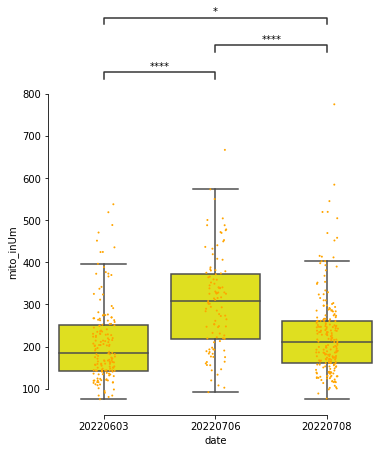

In [32]:
# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="date", y="mito_inUm", color='yellow', data=df_fix, showfliers = False, ax=axes)
sns.stripplot(x="date", y="mito_inUm", color="orange", data=df_fix, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=df_fix, x="date", y="mito_inUm", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)
plt.savefig(Path(outDir+"mitoCountPerDayStats.svg"))

#### iii) foci-density:

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

20220603 v.s. 20220706: Mann-Whitney-Wilcoxon test two-sided P_val=2.929e-02 U_stat=9.908e+03
20220706 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=3.634e-06 U_stat=7.611e+03
20220603 v.s. 20220708: Mann-Whitney-Wilcoxon test two-sided P_val=3.158e-03 U_stat=1.428e+04


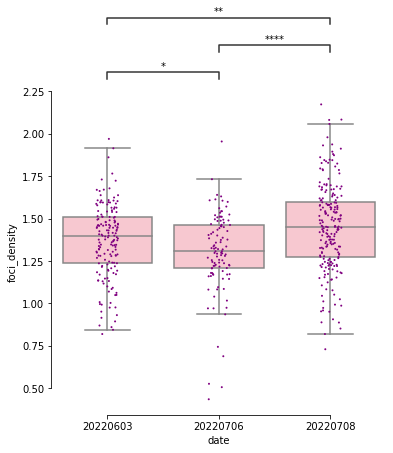

In [33]:
# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="date", y="foci_density", color='pink', data=df_fix, showfliers = False, ax=axes)
sns.stripplot(x="date", y="foci_density", color="purple", data=df_fix, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=df_fix, x="date", y="foci_density", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)
plt.savefig(Path(outDir+"fociDensityPerDayStats.svg"))

#### iv) technical replicates

In [100]:
print("number of samples on",'20220603','sample 2 = ', len(df_fix[(df_fix["date"]=='20220603')&(df_fix['sample']=='s2')]))
print("number of samples on",'20220603','sample 3 = ', len(df_fix[(df_fix["date"]=='20220603')&(df_fix['sample']=='s3')]))
print("number of samples on",'20220706','sample 2 = ', len(df_fix[(df_fix["date"]=='20220706')&(df_fix['sample']=='s2')]))
print("number of samples on",'20220706','sample 3 = ', len(df_fix[(df_fix["date"]=='20220706')&(df_fix['sample']=='s3')]))
print("number of samples on",'20220708','sample 2 = ', len(df_fix[(df_fix["date"]=='20220708')&(df_fix['sample']=='s2')]))
print("number of samples on",'20220708','sample 3 = ', len(df_fix[(df_fix["date"]=='20220708')&(df_fix['sample']=='s3')]))
print("number of samples on",'20220708','sample 1 = ', len(df_fix[(df_fix["date"]=='20220708')&(df_fix['sample']=='s1')]))

number of samples on 20220603 sample 2 =  76
number of samples on 20220603 sample 3 =  87
number of samples on 20220706 sample 2 =  41
number of samples on 20220706 sample 3 =  64
number of samples on 20220708 sample 2 =  60
number of samples on 20220708 sample 3 =  88
number of samples on 20220708 sample 1 =  65


foci count:

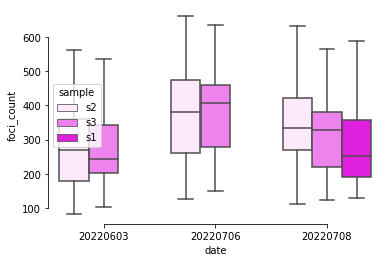

In [41]:
sns.boxplot(x="date", y="foci_count", hue="sample", color='magenta', data=df_fix, showfliers = False)
sns.despine(trim=True)
plt.savefig(Path(outDir+"fociPerSampleAll.svg"))

mitochondrial area:

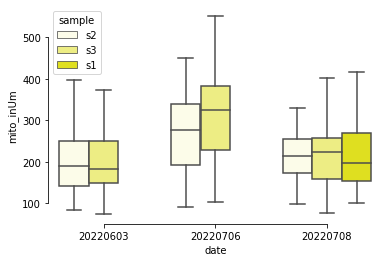

In [42]:
sns.boxplot(x="date", y="mito_inUm", hue="sample", color='yellow', data=df_fix, showfliers = False)
sns.despine(trim=True)
plt.savefig(Path(outDir+"mitoPerSampleAll.svg"))

foci density:

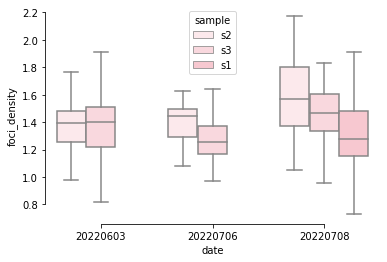

In [35]:
sns.boxplot(x="date", y="foci_density", hue="sample", color='pink', data=df_fix, showfliers = False)
sns.despine(trim=True)
plt.savefig(Path(outDir+"fociDensityPerSampleAll.svg"))

day 1: 20220603

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

s2 v.s. s3: Mann-Whitney-Wilcoxon test two-sided P_val=8.902e-01 U_stat=3.264e+03


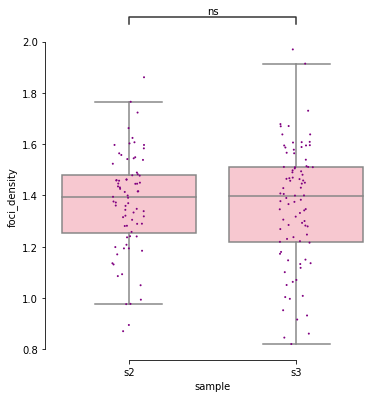

In [37]:
# define input parameters:
sorter      = ["s2", "s3"]
box_pairs   = [("s2", "s3")]
testtype    = 'Mann-Whitney'
dfdf        = df_fix[df_fix["date"]=='20220603']

# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="sample", y="foci_density", color='pink', data=dfdf, showfliers = False, ax=axes)
sns.stripplot(x="sample", y="foci_density", color="purple", data=dfdf, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=dfdf, x="sample", y="foci_density", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)
plt.savefig(Path(outDir+"fociDensityDay1Stats.svg"))

day 2: 20220706

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

s2 v.s. s3: Mann-Whitney-Wilcoxon test two-sided P_val=7.802e-04 U_stat=1.824e+03


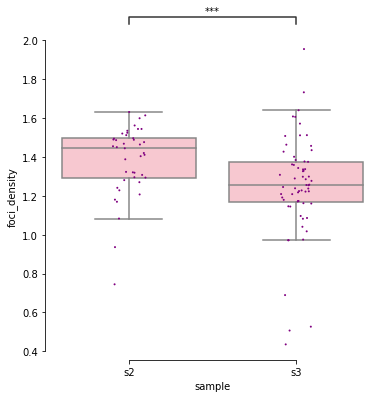

In [39]:
# define input parameters:
sorter      = ["s2", "s3"]
box_pairs   = [("s2", "s3")]
testtype    = 'Mann-Whitney'
dfdf        = df_fix[df_fix["date"]=='20220706']

# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="sample", y="foci_density", color='pink', data=dfdf, showfliers = False, ax=axes)
sns.stripplot(x="sample", y="foci_density", color="purple", data=dfdf, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=dfdf, x="sample", y="foci_density", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)
plt.savefig(Path(outDir+"fociDensityDay2Stats.svg"))

day 3: 20220708

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

s1 v.s. s2: Mann-Whitney-Wilcoxon test two-sided P_val=2.385e-07 U_stat=9.040e+02
s2 v.s. s3: Mann-Whitney-Wilcoxon test two-sided P_val=1.410e-02 U_stat=3.269e+03
s1 v.s. s3: Mann-Whitney-Wilcoxon test two-sided P_val=3.162e-05 U_stat=1.732e+03


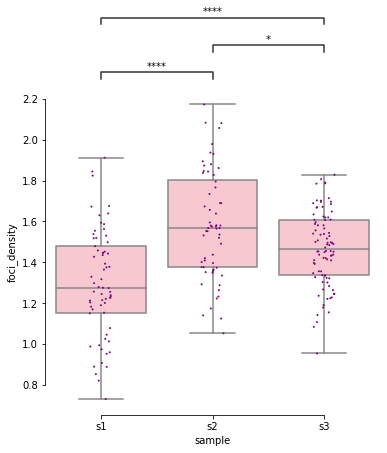

In [40]:
# define input parameters:
sorter      = ["s1","s2", "s3"]
box_pairs   = [("s1", "s2"), ("s2", "s3"), ("s1", "s3")]
testtype    = 'Mann-Whitney'
dfdf        = df_fix[df_fix["date"]=='20220708']

# create plot:
f, axes = plt.subplots(figsize=(6, 6))
sns.boxplot(x="sample", y="foci_density", color='pink', data=dfdf, showfliers = False, ax=axes)
sns.stripplot(x="sample", y="foci_density", color="purple", data=dfdf, size=2)
sns.despine(trim=True)

# add statistics:
add_stat_annotation(axes, data=dfdf, x="sample", y="foci_density", order=sorter, box_pairs = box_pairs,
        test=testtype, text_format='star', loc='outside', verbose=2)
plt.savefig(Path(outDir+"fociDensityDay3Stats.png"))